In [5]:
from sklearn.cluster import MiniBatchKMeans, KMeans
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from datasets import load_from_disk
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from collections import Counter
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score, v_measure_score

In [6]:
sampled_ds = load_from_disk("dataset-stackoverflow.hf")
np_ds = sampled_ds.with_format("numpy")
np_ds

Dataset({
    features: ['label', 'sentence', 'gte', 'stella', 'tsne_gte', 'tsne_stella'],
    num_rows: 20000
})

In [7]:
X = np_ds["stella"]

# Normalize the vectors (important for euclidean distance)
X_normalized = normalize(X)

# KMeans (Greedy KMeans++ variant)

In [8]:
kmeans = KMeans(
        n_clusters=4,
        init='k-means++',
        n_init=8,
    )
kmeans.fit(X_normalized)

KMeans(n_clusters=4, n_init=8)

In [38]:
colors = ['r', 'g', 'b', 'y']
class_names = sampled_ds.features['label'].names
index_to_colour_names = {i:(color, name) for i, (color, name) in enumerate(zip(colors, class_names))}
index_to_colour_names

{0: ('r', 'eosio'),
 1: ('g', 'fitness'),
 2: ('b', 'latin'),
 3: ('y', 'softwarerecs')}

In [46]:
print("new label, old label")
sorted(Counter(list(zip(kmeans.labels_.tolist(), np_ds["label"].tolist()))).items(), key=lambda x: (x[0][0], -x[1]))

new label, old label


[((0, 2), 4505),
 ((0, 0), 23),
 ((0, 1), 5),
 ((0, 3), 3),
 ((1, 0), 4983),
 ((1, 3), 39),
 ((1, 2), 4),
 ((1, 1), 2),
 ((2, 1), 4821),
 ((2, 2), 44),
 ((2, 0), 14),
 ((2, 3), 9),
 ((3, 3), 5289),
 ((3, 0), 192),
 ((3, 2), 45),
 ((3, 1), 22)]

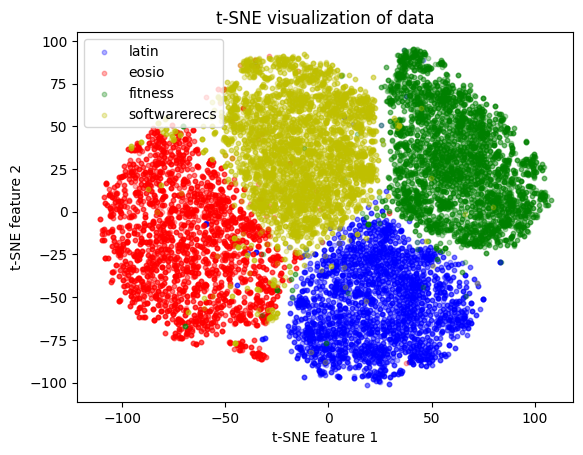

In [47]:
mapped_dict = index_to_colour_names.copy()
mapped_dict[0], mapped_dict[1], mapped_dict[2], mapped_dict[3] = mapped_dict[2], mapped_dict[0], mapped_dict[1], mapped_dict[3]

for i, (color, name) in mapped_dict.items():
    indices = kmeans.labels_ == i
    scatter = plt.scatter(np_ds['tsne_stella'][indices, 0], np_ds['tsne_stella'][indices, 1], 
                          c=color, 
                          s=10,  # Reduced dot size
                          alpha=0.3,  # Add transparency
                          label=name)

plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Add a text legend
plt.legend()

plt.show()

## Evaluation

0.16520086


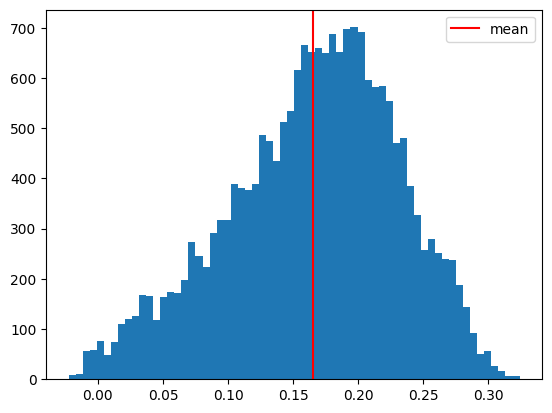

In [52]:
silhouette_all = silhouette_samples(X_normalized, kmeans.labels_, metric='cosine')
silhouette_avg = silhouette_all.mean()
print(silhouette_avg)

plt.hist(silhouette_all, bins=64)
plt.axvline(silhouette_avg, color = 'r', label='mean')
plt.legend()
plt.show()

- Sillhouete Score of 0.1652 is very close to baseline score of 0.1675
- Kmeans is an appropriate clustering method for this dataset

In [56]:
davies_bouldin_avg = davies_bouldin_score(X_normalized, kmeans.labels_)
print(davies_bouldin_avg)

3.068868650880034


Almost exactly the same Davies Bouldin score: 3.069 (kmeans) vs 3.073 (baseline)

In [13]:
v_measure_score(np_ds['label'], kmeans.labels_)

np.float64(0.914590963402292)

# MiniBatch KMeans

In [28]:
mb_kmeans = MiniBatchKMeans(
        n_clusters=4,
        batch_size=64,
        n_init=8,
    )
mb_kmeans.fit(X_normalized)

MiniBatchKMeans(batch_size=64, n_clusters=4, n_init=8)

In [29]:
colors = ['r', 'g', 'b', 'y']
class_names = sampled_ds.features['label'].names
index_to_colour_names = {i:(color, name) for i, (color, name) in enumerate(zip(colors, class_names))}
index_to_colour_names

{0: ('r', 'eosio'),
 1: ('g', 'fitness'),
 2: ('b', 'latin'),
 3: ('y', 'softwarerecs')}

In [30]:
print("new label, old label")
Counter(list(zip(mb_kmeans.labels_.tolist(), np_ds["label"].tolist())))

new label, old label


Counter({(0, 3): 5319,
         (3, 0): 4858,
         (1, 1): 4809,
         (2, 2): 4493,
         (0, 0): 336,
         (0, 2): 64,
         (0, 1): 35,
         (1, 2): 31,
         (3, 3): 12,
         (3, 2): 10,
         (1, 0): 10,
         (2, 0): 8,
         (2, 3): 7,
         (2, 1): 6,
         (1, 3): 2})

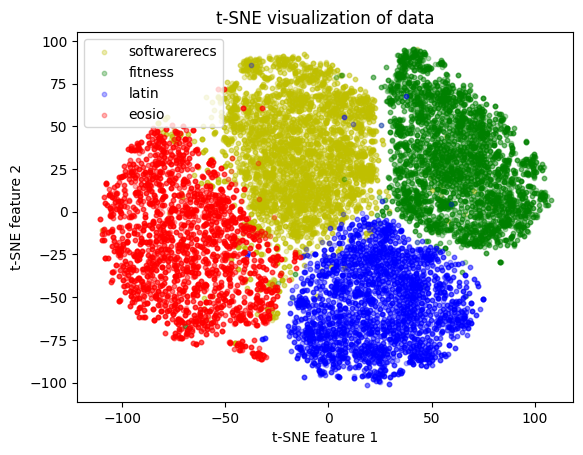

In [31]:
mapped_dict = index_to_colour_names.copy()
mapped_dict[0], mapped_dict[3], mapped_dict[1], mapped_dict[2] = mapped_dict[3], mapped_dict[0], mapped_dict[1], mapped_dict[2]

for i, (color, name) in mapped_dict.items():
    indices = mb_kmeans.labels_ == i
    scatter = plt.scatter(np_ds['tsne_stella'][indices, 0], np_ds['tsne_stella'][indices, 1], 
                          c=color, 
                          s=10,  # Reduced dot size
                          alpha=0.3,  # Add transparency
                          label=name)

plt.title('t-SNE visualization of data')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')

# Add a text legend
plt.legend()

plt.show()

## Evaluation

0.16912608


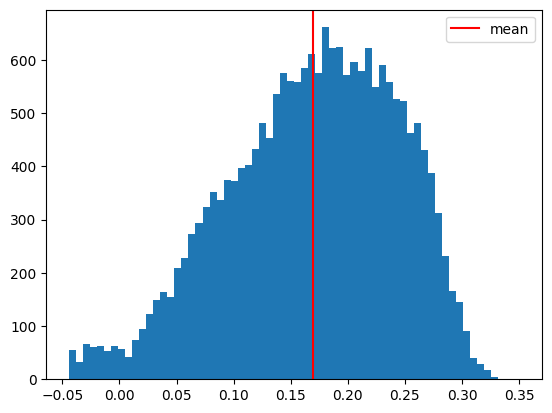

In [32]:
silhouette_all = silhouette_samples(X_normalized, mb_kmeans.labels_, metric='cosine')
silhouette_avg = silhouette_all.mean()
print(silhouette_avg)

plt.hist(silhouette_all, bins=64)
plt.axvline(silhouette_avg, color = 'r', label='mean')
plt.legend()
plt.show()

- Sillhouete Score of Mini-Batch Kmeans is the same as that of Kmeans++ at 0.1652
- Mini Batch Kmeans does not offer any meaningful improvement over the standard algorithm for this dataset

In [33]:
davies_bouldin_avg = davies_bouldin_score(X_normalized, mb_kmeans.labels_)
print(davies_bouldin_avg)

3.059178489806068


Same Davies Bouldin score, supports above conclusion on Kmeans++ vs Mini-Batch Kmeans

In [34]:
v_measure_score(np_ds['label'], mb_kmeans.labels_)

np.float64(0.9130848926409565)